<img src="img/logos.png" style="width:280px; float: right">

# Detection of vegetation loss 
### ... as  a first step towards detecting rapid population growth from satellite imagery 

--- 
`Event: Missing maps Hackathon Pilsen`   
`Where: Pilsen, Czech Republic`   
`When:  October 11-13, 2019`   
`Who:   Jan Benetka & Jakub Matějka`

---


This notebook demonstrates work of Jan Benetka and Jakub Matějka carried out during the first <a href="https://www.eventbrite.com/e/missing-maps-hackathon-pilsen-hackathon-s-lekari-bez-hranic-registration-74140796117">**Missing Maps & MSF Hackathon**</a> organized in the Czech Republic. 
The goal of our challenge is to identify rural locations with **potential population growth**. 

<img src="https://c402277.ssl.cf1.rackcdn.com/photos/9411/images/magazine_hero/EB_072014_Purus_145.jpg?1436381115">

*(Image credits: Nicolas Villaume for <a href="https://www.worldwildlife.org/magazine/issues/fall-2015/articles/deforestation-in-peru" target="_blank">WWF Magazine Articles</a>)*


--
### Task & Reasoning
Expansion of population in certain area is almost always accompanied with side effects such as increased number of houses and consequent emergence of paths among them, loss of trees in nearby forests (used for heating or cooking), or degradation of natural environment due to the industrial growth. A common denominator of all of these effects is a decrease of vegetation mass. 
Our aim, therefore, is to come up with a **simple yet effective methods to detect loss of greenery and analyze its rate**.


---


### Data 

After brief search for available datasets, we settled on images from the <a href="https://sentinel.esa.int/web/sentinel/missions/sentinel-2">Copernicus Sentinel-2</a> mission. It provides multi-spectral images of the Earth that are publicly available. Morover, the satellite(s) revisits the same area with high frequency (~5-10 days), which increases our chances of collecting nice cloud-free snapshots. The pictures come in a spatial resolution that varies from 10m/pixel for some spectral bands (RGB, NIR), through 20m/pixel (e.g., Red Edge), up to 60m/pixel (<a href="https://www.hatarilabs.com/ih-en/how-many-spectral-bands-have-the-sentinel-2-images">see complete list</a>). It is not quite enough for reliable recognition of people or rooftops, nevertheless, it is fine for spotting variations in vegetation levels.

One tool that certainly deserves our mention is the <a href="https://apps.sentinel-hub.com/eo-browser/">**EO browser**</a> by SINERGISE. Not only you can download the satellite images here, you can also visualize and choose any of the available spectral bands. On top of that, the browser has a function to create a timelapse from imagery for a given region and you can decide what percentage of clouds you are able to tolerate in the pics.


---


### Method(s) 

#### TL;DR
Simply put, we take two satellite images from the same area in two different moments and we look for differences in vegetation. We then highlight these differences for each consecutive pair of snapshots and measure their rate.

#### Long version

***1) Vegetation identification***

Trying to distinguish vegetation based on color in visible spectrum might work for some areas (lush grasslands), but not for others (autumn tundra). Much better way of vegetation remote-sensing is to understanding that plants, in order to produce sugar via photosynthesis, do absorb solar radiation of certain wavelengths (see figure below) while they reflect other ranges not to overheat. SENTINEL-2 is well-equipped to capture images in red and near-infrared spectrum, and those are the wavelenght ranges needed to calculate **NDVI: Normalized difference vegetation index**. High values of NDVI index represent rich vegetation, low values suggest lack of greenery. The index is computed as:
$NDVI=\frac{(NIR - RED)}{(NIR + RED)}$, where NIR is near-infrared spectrum and RED is red (visible) spectrum.



<table>
<tr><td> <img src="img/photosynthesis.png" alt="Photosynthesis and wavelength ranges." style="width: 650px;"/> 
</td></tr>
<td style="text-align:left">Ranges of solar radiation wavelength where photosynthesis happens. Refer to <a href="https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index" target="_blank">Wikipedia article about NDVI.</a> to find more information.</td>
</table>

*Below, you can see a satellite image of Manhattan in NDVI mode as well as in true color spectrum:*

In [2]:
from IPython.display import IFrame
IFrame("https://cdn.knightlab.com/libs/juxtapose/latest/embed/index.html?uid=277dc0bc-f44e-11e9-b9b8-0edaf8f81e27", width=980, height=400)

***2) Vegetation change tracking***

We saw that in the "NDVI world" brigh equals little vegetation, dark means a lot. Next step, naturally, is to compare two temporally different snapshots from the same area and calculate the extent of vegetation loss. We simply compute per-pixel differences between two images $I_1$ and $I_2$:

$I_d = |I_1(x,y) - I_2(x,y)|$

after first converting them to grayscale and normalizing their contrast/brightness:

$I_{2\_norm} = \frac{\sigma_1}{\sigma_1}(I_2(x,y) - \nu_2)+\nu_1$,

where $\sigma$ is mean brightness and $\nu$ is mean contrast. Find the method described at [sentinel-hub blog](https://medium.com/sentinel-hub/next-mission-automated-detection-of-land-changes-8e988dce55ff).


*An example of a (quick) deforestation process captured on two NDVI snapshots converted to grayscale looks like this:*

In [3]:
IFrame("https://cdn.knightlab.com/libs/juxtapose/latest/embed/index.html?uid=6cf302a2-f452-11e9-b9b8-0edaf8f81e27", width=980, height=350)

*Image pairs like that serve as our input data to express the differences (marked below in red color):*

<img src="img/amazon_diff.png" style="width:980px; margin:0">

------

# Code

The second part of this notebook contains code that translates the ideas above into analyses of various areas in the  last section. 

Warning! The code is a little hacky - it is a hackathon code, after all...

In [4]:
import sys
import numpy as np
import pandas as pd
from scipy.stats import linregress
import glob
from PIL import Image, ImageOps
from datetime import datetime, timedelta

from IPython.display import display, HTML

import ipywidgets as widgets
from ipywidgets import interact

import matplotlib.pyplot as plt
import plotly.graph_objects as go

### Functions

***Helper methods***

In [5]:
"""
infrastructure methods
""" 
def load_image(path, band='True', max_width=-1):
    """
    Loads and, if required, resizes image.
    Returns an RGBA PIL image.
    """
    try:
        path = glob.glob(path + '/*' + band + '*.png')[0]
        img = Image.open(path).convert('RGBA')
        # resize image if required
        if(max_width > 0): 
            return image_resize(img, max_width)
        else:
            return img
    except Exception as e:
        print('Problem in finding file and parsing date: ' + str(e))
        
def load_path_dates(area):
    """
    Returns dates of all existing snapshots for 
    a given area mapped to the snapshots' path.
    """
    mapping = {}

    for path in sorted(glob.glob('./data/' + area + '/*')):
        date = parse_date(path, as_string=True)
        mapping[date] = path

    return mapping
        
def parse_date(path, band='True', as_string=False):
    """
    Parses image date given its path. 
    Implicitly returns datetime object,
    if 'as_string=True' returns string.
    
    """
    try:
        path = glob.glob(path + '/*' + band + '*.png')[0]
        date_str = path.split(',')[0].split('/')[-1]
        date = datetime.strptime(date_str,'%Y-%m-%d')
    except Exception as e:
        print('Problem in finding file and parsing date: ' + str(e))    
        
    if(as_string):
        return date_str
    
    return date
            
def image_resize(img, max_w):
    """
    Resizes 'img' to 'max_w' width.
    """
    size = img.size
    ratio = max_w / size[0]
    return img.resize((int(size[0]*ratio), int(size[1]*ratio)), Image.ANTIALIAS)
        
"""
image-processing methods
""" 
def image_gray2red(arr):
    """
    Convert grayscale image to red RGBA image. 
    """
    zer = np.zeros((arr.shape))
    one = np.ones((arr.shape)) * 255
    return np.stack((one, zer, zer, arr), axis=2)    
            
def overlay(bg_img, fg_arr, grayscale_bg=True):

    if(grayscale_bg):
        bg_img = bg_img.convert('LA').convert('RGBA')
    
    # turn the differences to red
    red_img = Image.fromarray(image_gray2red(fg_arr).astype('uint8'), 'RGBA')
    # overlay red image over grayscale img
    return Image.fromarray(np.array(Image.alpha_composite(bg_img, red_img) \
                .convert('RGBA')) \
                .astype('uint8'), 'RGBA')

def get_brightness(image):
    return np.mean(np.array(image.convert('L')).astype('float'))
    
def get_contrast(image):
    return np.std(np.array(image.convert('L')).astype('float'))  


***Deforestation processing & analysis methods***

In [6]:
def calculate_difference_matrix(im1, im2, THRESHOLD_LOW=0,  THRESHOLD_HIGH=255):
    """
    Returns a matrix D=Y-X, where Y is a matrix containing pixels 
    of image 'im2' and X is a matrix containing pixels of image 'im1'.
    
    The images im1, im2 are first converted into grayscale and then
    contrast- and brightness-normalized. 
    
    THRESHOLD_LOW and THRESHOLD_HIGH define the range of values that
    are counted as difference.
    """
    #greyscale_image = image.convert('L')
    
    arr1 = np.array(im1.convert('L')).astype('float')
    arr2 = np.array(im2.convert('L')).astype('float')
    
    sigma_im1 = get_brightness(im1)
    sigma_im2 = get_brightness(im2)    
    mi_im1 = get_contrast(im1)
    mi_im2 = get_contrast(im2)    
    
    # prvent division by 0
    sigma_im2 = sigma_im2 if sigma_im2 > 0 else 1
        
    # normalize brightness & contrast
    im2_norm = (sigma_im1 / sigma_im2) * (arr2 - mi_im2) + mi_im1

    # calculate difference
    idiff = arr2 - arr1
    
    # zero out the negative values
    idiff = np.where(idiff < 0, 0, idiff)
    
    # filter for THRESHOLD
    idiff = np.where(idiff > THRESHOLD_HIGH, 0, idiff)
    idiff = np.where(idiff < THRESHOLD_LOW, 0, idiff)     
    
    return idiff

def deforestation_percentage(diff, threshold_vegetation):
    """
    Returns % of different pixels in 'diff' matrix.  
    'threshold_vegetation' sets tolerance margin for vegetation assignment.
    """
    vegetation_pixels = np.where(diff > threshold_vegetation)
    fraction = len(vegetation_pixels[0]) / diff.size
    return 100 * fraction # counting in percent

def compare_snapshots(path1, path2, band='NDVI', THRESHOLD_LOW=0,  THRESHOLD_HIGH=255):
    """
    Calculate the difference between two snapshots (path1, path2) in the spectrum
    given by the band variable. 
    
    Returns the whole record about the comparison including the original images, 
    dates, # of days dividing the snapshots, difference matrix, diff. image and 
    the true image overlayed with differences (in red).
    """
    
    # store comparison details
    record = {}
    
    # data for figure no.1
    date1 = parse_date(path1)
    im1_true = load_image(path1, band='True')
    im1_band = load_image(path1, band=band)
    
    # data for figure no.2
    date2 = parse_date(path2)
    im2_true= load_image(path2, band='True')
    im2_band = load_image(path2, band=band)
    
    # diff (im_x, im_x+1); diff_first (im_0, im_x+1); 
    diff = calculate_difference_matrix(im1_band, im2_band, THRESHOLD_LOW,  THRESHOLD_HIGH)

    # percentage
    time_delta = (date2-date1).days

    record['im1'] = im1_true
    record['im2'] = im2_true
    record['im1_band'] = im1_band
    record['im2_band'] = im2_band  
    record['diff'] = diff
    record['im_diff_red'] = Image.fromarray(image_gray2red(diff).astype('int8'), 'RGBA')
    record['im_diff_overlay'] = overlay(im1_true, diff) 
    record['date1'] = date1.strftime("%Y-%m-%d")
    record['date2'] = date2.strftime("%Y-%m-%d")
    record['date_delta'] = time_delta
    
    return record

def generate_all_comparisons(area, max_width=-1, band='NDVI', THRESHOLD_LOW=0,  THRESHOLD_HIGH=255):
    """
    Processes all images and generates comparison 
    between two consecutive images.
    
    area: name of the folder with area's images
    THRESHOLD_LOW: lower bound of masking range (higher values are ignored)
    THRESHOLD_HIGH: upper bound of masking range (higher values are ignored)
    """
    
    # store compario
    comparisons_consecutive = {} # keep comparisons with consecutive pairs 
    comparisons_absolute = {}    # compare each snapshot with the very first snapshot
    
    # load figures from area
    snapshot_paths = sorted(glob.glob('./data/' + area + '/*'))
    
    if(len(snapshot_paths) < 2):
        raise ValueError('More than 1 snapshot needed for comparison.')
    
    # keep the first image for comparison
    path0 = snapshot_paths[0]

    # process each image
    for ix in range(1, len(snapshot_paths)):
        
        path1 = snapshot_paths[ix-1]
        path2 = snapshot_paths[ix]
        comp_consecutive = compare_snapshots(path1, path2, band=band,
                                             THRESHOLD_LOW=THRESHOLD_LOW, 
                                             THRESHOLD_HIGH=THRESHOLD_HIGH)
        
        comp_absolute = compare_snapshots(path0, path2, band=band,
                                          THRESHOLD_LOW=THRESHOLD_LOW, 
                                          THRESHOLD_HIGH=THRESHOLD_HIGH)
        
        comparisons_consecutive[comp_consecutive['date2']] = comp_consecutive
        comparisons_absolute[comp_absolute['date2']] = comp_absolute        
    
    return comparisons_absolute, comparisons_consecutive


***Visualization & Interaction methods***

In [7]:
def plot_area_map(lon=0, lat=0, width=1000, height=400):
    """
    Plots a mapbox map with the location of interest marked red.
    """
    
    mapfig = go.Figure(go.Scattermapbox(
        fill = "toself", 
        lon = [lon], lat= [lat],
        marker = { 'size': 17, 'color': "red" }))


    mapfig.update_layout(
        width=width, height=height,
        mapbox = {
            'center': {'lon': lon, 'lat': lat}, 
            'zoom': 1},
        mapbox_style="white-bg",
        mapbox_layers=[
            {
                "below": 'traces',
                "sourcetype": "raster",
                "source": [
                    "https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"
                ]
            }
          ],
        margin={"r":0,"t":0,"l":0,"b":0}
    )

    mapfig.show()
    
def show_deforestation_photoline(comparisons, width=1200):
    """
    Combines all snapshots, chronologically ordered.
    Three layers include: true image, band image, difference.
    """
    _dates = sorted(comparisons.keys())[1:]
    
    thumb_width = int(width / len(_dates))
    
    true_images  = [image_resize(comparisons[d]['im2'], thumb_width) for d in _dates]
    ndvi_images  = [image_resize(comparisons[d]['im2_band'], thumb_width) for d in _dates]
    red_images   = [image_resize(comparisons[d]['im_diff_red'], thumb_width) for d in _dates]    
    
    thumb_height = image_resize(true_images[0], thumb_width).size[1]
    
    collage = Image.new('RGBA', (len(_dates) * thumb_width, thumb_height * 3))
    offset_x = 0

    for ix, d in enumerate(_dates):
        collage.paste(true_images[ix], (offset_x, 0))
        collage.paste(ndvi_images[ix], (offset_x, thumb_height))
        collage.paste(red_images[ix], (offset_x, thumb_height * 2))    
        offset_x += thumb_width

    return collage

def plot_deforestation_progress(comparisons, width=1000, height=400):
    """
    Plots the measured and predicted (lin. regression) 
    deforestation over time.
    """
    
    # get values for deforestation
    _dates = sorted(comparisons.keys())[1:]
    dfrst_abs = [deforestation_percentage(comparisons[d]['diff'], 0) for d in _dates]

    # make a regression line to see the trend
    X = list(range(0, len(dfrst_abs)))
    y = dfrst_abs
    slope, intercept, r_value, p_value, std_err = linregress(X,y)
    y_pred = intercept + slope *  pd.Series(X)


    # Create traces
    fig = go.Figure()

    # measured deforestation data
    fig.add_trace(go.Scatter(x=_dates, y=dfrst_abs,
                        hovertemplate = "Date: %{x} | Deforestation: %{y:.2f}%<extra>Measured</extra>",
                        mode='lines+markers',
                        name='Deforestation (absolute)',
                        marker=dict(size=11),
                        line=dict(color='green', width=4)))

    # trend regression
    fig.add_trace(go.Scatter(x=_dates, y=y_pred,
                        hovertemplate = "Date: %{x} | Deforestation: %{y:.2f}% <extra>Predicted trend</extra>",                        
                        mode='lines',
                        name='Deforestation trend',
                        line=dict(color='red', width=4, dash='dash')))



    fig.update_layout( #title='Deforestation progress in ' + area,
                       xaxis_title='Date',
                       yaxis_title='% deforested',
                       hovermode = 'x',
                       width=width, height=height,
                       plot_bgcolor='#f2f7f4',
                       margin={"r":15,"t":25,"l":45,"b":15})

    fig.show()
    
def display_difference_viz(date_range):
    """
    Generate interactive visualization 
    of differences between 2 snapshots.
    """
    comparison = compare_snapshots(paths[date_range[0]], 
                                   paths[date_range[1]], 
                                   band=band,
                                   THRESHOLD_LOW=0,  
                                   THRESHOLD_HIGH=255)
    display(generate_comparison_collage(comparison, width=1000))         
    
def generate_comparison_collage(comparison, width=-1):
    """
    Combines snapshot images into a collage of 4 images.
    Layout:
    
    true_before  |  difference  |  true_after
    grayscale(true_before)  +  red(difference)
    
    """
    
    _width, _height = comparison['im1'].size # get original image size
    _thumb_width, _thumb_height = int(_width/3), int(_height/3) # dimensions of thumbnails
    
    # prepare (resize) images for collage
    before = image_resize(comparison['im1'], _thumb_width)
    after = image_resize(comparison['im2'], _thumb_width)
    diff_red = image_resize(comparison['im_diff_red'], _thumb_width)
    overlay = comparison['im_diff_overlay']

    # combine images into new image
    collage = Image.new('RGBA', (_width, _thumb_height + _height))
    collage.paste(before,   (0, 0))
    collage.paste(diff_red, (_thumb_width, 0))
    collage.paste(after,    (2*_thumb_width, 0))
    collage.paste(overlay,  (0, _thumb_height))    

    if(width > 0):
        collage = image_resize(collage, width)
        
    return collage

***Run whole analysis***

In [8]:
def analyze_area(area, lat=0, lon=0, band='NDVI', threshold_low=0, threshold_high=255, width=990):
    """
    Runs the whole analysis for chosen `area' 
    and selected parameters. The lat/lon arguments 
    are only used to pintpoint the area on a map.
    
    Thresholds are there to calibrate the vegetation
    recognition range on grayscale images.
    """

    c_absolute, c_consecutive = generate_all_comparisons(area, 
                                                         max_width=-1, 
                                                         band=band,
                                                         THRESHOLD_LOW=threshold_low, 
                                                         THRESHOLD_HIGH=threshold_high)
    paths = load_path_dates(area)
    _dates = sorted(paths.keys())[1:]

    display(HTML('<h1>Deforestation analysis in ' + area.upper() + '</h1>'))
    print('LOCATION |', 'Latitude: ' + str(lat), '     ',   'Longitude: ' + str(lon))
    print('DATE     |', 'From:     ' + str(_dates[0]),'   ','Till:      '      + str( str(_dates[-1])) )

    plot_area_map(lon=lon, lat=lat, width=width,height=300)

    display(HTML('<h3>Deforestation progress</h3>'))
    display(HTML('Over the course of time we first collect a series of satellite images from a selected area.\
                  We then calculate the percentage of deforested areas and plot these measurements in the \
                  graph below (green line). Since the image and vegetation conditions might vary \
                  (rainy season, overcast, etc.), we follow the long-term trend that is not susceptible to \
                  short-term extremes (dashed red line).'))
    plot_deforestation_progress(c_absolute, width=width, height=300)

    display(HTML('<h3>Snapshot timeline</h3>'))
    display(HTML('Here we show the underlying satellite imagery in the chronological order. The upper \
                 images depict the area in the visible spectrum, the middle images show the same area in \
                 <a href="https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index">NDVI mode</a> \
                 that recognizes vegetation, and the lower images highlight the areas with vegetation reduction \
                 compared to the initial state of the analysis.'))
    display(show_deforestation_photoline(c_absolute))


    display(HTML('<h3>Visualize snapshot difference</h3>'))
    display(HTML('We can compare and visualize the deforestation progress between two snapshots. \
                  By adjusting two-sided slider, one can choose the temporal interval of interest, \
                  which, after clicking the button ("Run interact"), will highlight the diffrences \
                  in vegetation.'))

    
    def display_difference_viz(date_range):
        """Generate interactive visualization of differences between 2 snapshots."""
        comparison = compare_snapshots(paths[date_range[0]], 
                                       paths[date_range[1]], 
                                       band=band,
                                       THRESHOLD_LOW=threshold_low,  
                                       THRESHOLD_HIGH=threshold_high)
        display(generate_comparison_collage(comparison, width=width))         

    # define slider
    selection_range_slider = widgets.SelectionRangeSlider(
        options = sorted(paths.keys()),
        index = (0, len(paths)-1),
        description = 'Dates',
        orientation = 'horizontal',
        layout = {'width': '750px'}
    )

    # make slider interactive
    widgets.interact_manual(
        display_difference_viz,
        date_range = selection_range_slider
    )

----

# Deforestation Analysis

Finally, we can test our methods on some areas where deforestation is an issue.  
The analysis output has 4 components:

 - **Map with location of the area**
 
 
 - **Deforestation progress** - data measured from the satellite imagery plotted on a timeline along with a long-term trend calculated using linear regression.
 
 
 - **Snapshot timeline** - visualization of all chronologically ordered images that are available for the analysis (3 variants: NDVI, True color, Difference between consecutive snapshots).
 
 
 - **Visualization of snapshot difference** - possibility to compare the deforestation process between arbitrary two snapshots. 
 
 
 Note:
 
In some cases, our method produces some **anomaly results** that can be easily spotted on the deforestation progress graph (see below). These outliers are typically caused by some "bad" imagery and can be eliminated by excluding such pictures from the analysis or by fine-tuning thresholds of the *deforestation-recognition sensitivity* (<a href="#thresholds">find our more</a>).

<img src="img/anomaly.png">

---

### General Settings

In [9]:
BAND = 'NDVI' # ['SWIR', 'NDSI', 'Scene', 'NDVI', 
              #  'True color','False color', 'NDWI', 
              #  'Moisture index', 'False color (urban)']

---

LOCATION | Latitude: -13.05218       Longitude: -70.17466
DATE     | From:     2016-09-17     Till:      2019-09-27


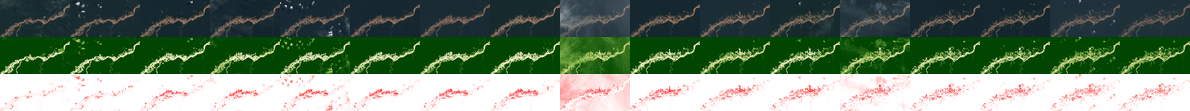

interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 18), layout=Layout(width='750px'), o…

In [10]:
analyze_area('amazon', lat=-13.05218, lon=-70.17466, band=BAND, threshold_low=10, threshold_high=255)

---

LOCATION | Latitude: 21.18889       Longitude: 92.15063
DATE     | From:     2016-01-05     Till:      2019-04-24


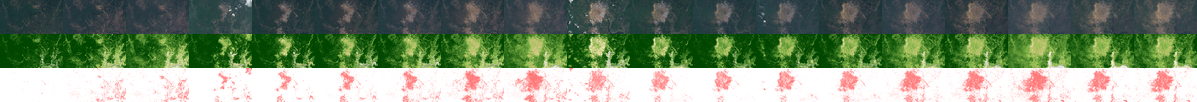

interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 20), layout=Layout(width='750px'), o…

In [11]:
analyze_area('bangladesh', lat=21.18889, lon=92.15063, band=BAND, threshold_low=72, threshold_high=166)

---

LOCATION | Latitude: -12.836       Longitude: -70.1292
DATE     | From:     2016-09-17     Till:      2019-09-17


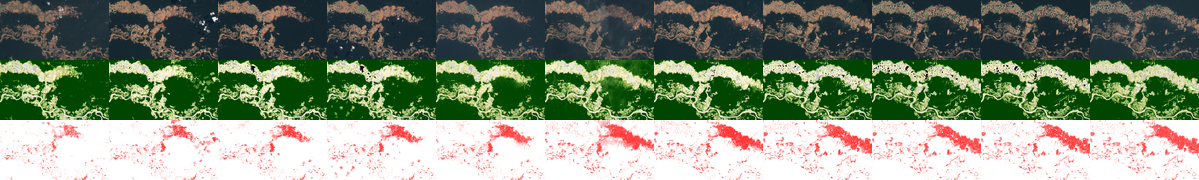

interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 12), layout=Layout(width='750px'), o…

In [12]:
analyze_area('gold_mine', lat=-12.8360, lon=-70.1292, band=BAND, threshold_low=30, threshold_high=255)

---

LOCATION | Latitude: 36.47845       Longitude: 127.30476
DATE     | From:     2017-04-13     Till:      2019-09-30


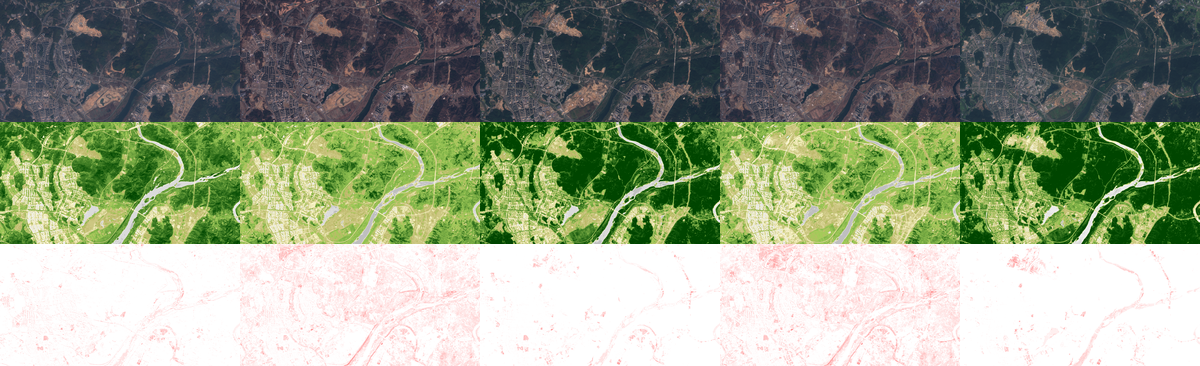

interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 6), layout=Layout(width='750px'), op…

In [13]:
analyze_area('sejong', lat=36.47845, lon=127.30476, band=BAND, threshold_low=0, threshold_high=255)

---

<a name="thresholds"></a>
### Calibrating deforestation-recognition sensitivity

In some cases, the trustworthiness of the comparison between two snapshots is hampered by bad imagery. This happens mostly due to slight variations in the dark (vegetation-rich) areas or due to sudden change in NDVI index caused by bright clouds being present on one of the images. To eliminate such cases we can simply ignore differences recognized on both extremes, i.e., too negligible or too abrupt changes in vegetation on consequent snapshots. This we can do by triming the extremes from the original 255 levels of vegetation differences by setting low and high thresholds.

We provide interactive tool to set the thresholds so that we loose minimal amount of valid information about deforestation:

In [14]:
def find_threshold(LOW, HIGH):
    comparison = compare_snapshots(p1, p2, band='NDVI', THRESHOLD_LOW=LOW, THRESHOLD_HIGH=HIGH)
    display(Image.fromarray(comparison['diff'].astype('uint8'),'L'))
    return LOW, HIGH

p1 = "./data/bangladesh/EO_Browser_images (09)"
p2 = "./data/bangladesh/EO_Browser_images (21)"

t = interact(find_threshold, 
             LOW=widgets.IntSlider(min=0, max=255, step=2, value=0),  
             HIGH = widgets.IntSlider(min=0, max=255, step=2, value=255))

interactive(children=(IntSlider(value=0, description='LOW', max=255, step=2), IntSlider(value=255, description…

---

# Resources



There are tons of resources available on the topic of deforestation. We found the following especially useful:


**Data**

- All about Sentinel missions: https://sentinel.esa.int/web/sentinel/home
- EO Browser @ Sentinel HUB: https://apps.sentinel-hub.com/eo-browser/


**Tutorials & Blog posts**

- [Land Cover Classification with eo-learn: Part 1 (by Matic Lubej
)](https://medium.com/sentinel-hub/land-cover-classification-with-eo-learn-part-1-2471e8098195)
- [Next mission — Automated detection of land changes (by Sinergise)](https://medium.com/sentinel-hub/next-mission-automated-detection-of-land-changes-8e988dce55ff)
- [How to use open source satellite data for your investigative reporting (by Ben Heubl et al.)](https://towardsdatascience.com/how-to-use-open-source-satellite-data-for-your-investigative-reporting-d662cb1f9f90)
- [EEUS2018-JupyterSession (by Tyler Erickson)](https://github.com/tylere/EEUS2018-JupyterSession)


**Image sources**

- Header image: [Nicolas Villaume @ WWF | Deforestation in Peru](https://www.worldwildlife.org/magazine/issues/fall-2015/articles/deforestation-in-peru)
- NDVI & Photosynthesis: [John Whitmarsh and Govindjee @ Wikipedia](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index#/media/File:Par_action_spectrum.gif)

**Tools**

- Image slider: https://juxtapose.knightlab.com/

---

Any questions? ..drop me a message at benetka@pm.me

---

<center>-8-</center>